# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral, qmc_time_ordered_integral_n_samples, qmc_time_ordered_integral_sort

import Sobol: SobolSeq
import LinearAlgebra: norm

import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

include("DelaunaySimplex.jl");

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1423
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## Single correlated atom coupled to a bath level

System parameters

In [2]:
β = 10.;         # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
#ϵ = [-0.1, +0.1] # Bath energy levels
ϵ = [-1.0, +1.0] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [3]:
nt = 2;
ntau = 11;
#ntau = 5001;
tmax = 1.0;

Exact Diagonalization

In [4]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [5]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [6]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

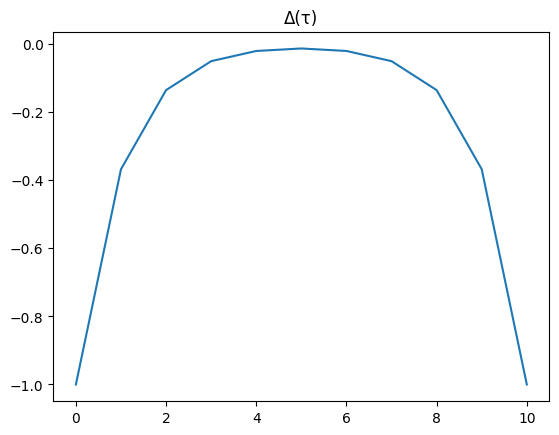

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/igor/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [7]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

tau = Array(LinRange(0, β, 101))

b = contour[kd.imaginary_branch]
t0 = b(tau[1])
times = [ b(t/β) for t in tau ]
vals = [ Δ(t, t0) for t in times ]

plt.title("Δ(τ)")
plt.plot(tau, imag.(vals), "-");

Pseudo Particle Strong Coupling Expansion

In [8]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

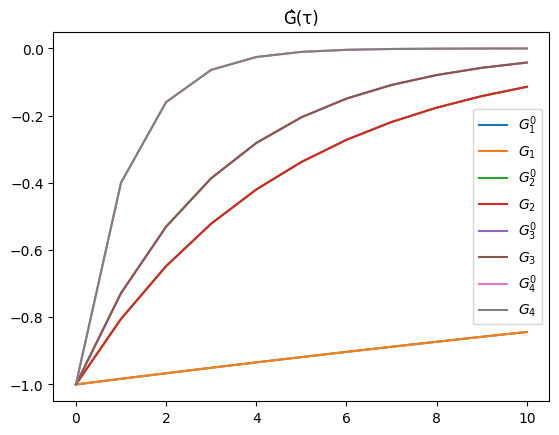

In [9]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

plt.title("Ĝ(τ)")
for (idx, G_s) in enumerate(ppsc_exp.P0)
    vals = [ G_s(t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="\$G^{0}_$idx\$")

    vals = [ ppsc_exp.P[idx](t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="\$G_$idx\$")
end

plt.legend(loc="best");

2nd order inchworm diagram on the imaginary branch

In [10]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w_idx = 1 + Int(τ_w_pos * (ntau - 1))
τ_w = tau_grid[τ_w_idx]

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

Quasi Monte Carlo integration over a $d = 3$ domain

In [11]:
function second_order_diag_eval(τ)
    # Loop over spin indices of hybridization lines
    sum = deepcopy(init_0)
    for index1 = 1:2, index2 = 1:2
        # 4 arrangements of creation and annihilation operators
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
    end
    return sum
end

second_order_diag_eval (generic function with 1 method)

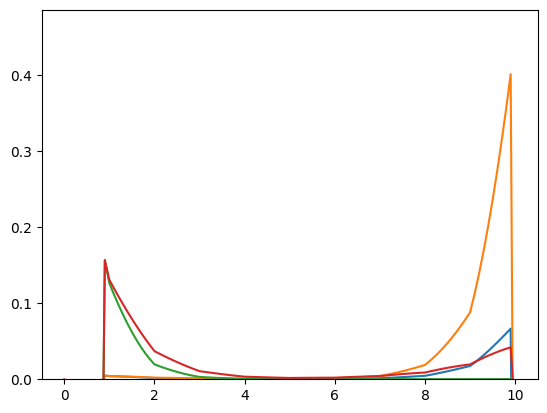

t1 = b(tau[10] / β) = Keldysh.BranchPoint(0.0 - 0.8999999999999999im, 0.09, Keldysh.imaginary_branch)


(0.0, 0.48615996431070213)

In [12]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

@show t1 = b(tau[10]/β)

vals = [ second_order_diag_eval([b(t/β), t1, t0]) for t in tau ]

for s in 1:4
    val_s = [ d[s][2] for d in vals ]
    val_s = vcat(val_s...)    
    plt.plot(tau, imag.(val_s))
end

plt.ylim(bottom=0)

# Test a single value of the integrand

In [13]:
@show τ = [tau_grid[end-4].bpoint, tau_grid[end-6].bpoint, tau_grid[end-8].bpoint]

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
@show s;

τ = [(tau_grid[end - 4]).bpoint, (tau_grid[end - 6]).bpoint, (tau_grid[end - 8]).bpoint] = Keldysh.BranchPoint[Keldysh.BranchPoint(0.0 - 6.0im, 0.6, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 4.0im, 0.4, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 2.0im, 0.2, Keldysh.imaginary_branch)]
Δ(n_f.time, τ[2]) = 0.0 - 0.020793447044365202im
Δ(τ[2], n_f.time) = 0.0 + 0.020793447044365202im
Δ(τ[1], τ[3]) = 0.0 - 0.020793447044365202im
Δ(τ[3], τ[1]) = 0.0 + 0.020793447044365202im
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}()
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}()
v3 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}()
v4 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}()
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}(3 => (3, [0.0 + 2.218298681908598e-5im;;]))
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64, Tuple{Int64, Matrix{

# Adaptive integration

In [14]:
import MultiQuad: tplquad

func_sector(z, y, x, sector) = -imag(second_order_diag_eval([b(z/β), b(y/β), b(x/β)])[sector][2][1, 1])

tau_w = τ_w_pos*β

quad_res = [ tplquad((z,y,x) -> func_sector(z, y, x, s), 
        0, tau_w, x->x, x->tau_w, (x,y)->y, (x,y)->tau_w, rtol=1e-3, atol=1e-3) for s in 1:4]

quad_integral = [ s[1] for s in quad_res ]
quad_error = [ s[2] for s in quad_res ]

@show quad_integral;
@show quad_error;

quad_integral = [-0.06336027096917136, -0.06130615917117405, -0.28259487204782524, -0.27688169139560287]
quad_error = [0.0009784110198115341, 0.0007747085399769642, 0.0009907864134354781, 0.000999825965597602]


# Delaunay triangulation and integration

In [15]:
tau_vals = [-imag(t.bpoint.val) for t in tau_grid]
points, simplices = DelaunaySimplex.triangulate(tau_vals[1:τ_w_idx], 3);

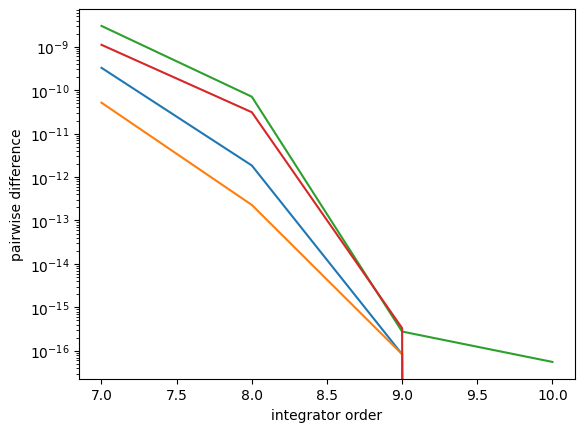

val(6)    = [-0.06379984933819405, -0.06381550800127937, -0.28263395652527723, -0.2781215844125249]
val(7)    = [-0.0637998490135754, -0.06381550805297442, -0.28263395344623704, -0.2781215832767411]
diff      = [3.24618651403874e-10, -5.1695051017652816e-11, 3.079040189479798e-9, 1.135783800343404e-9]
val(8)    = [-0.06379984901172973, -0.06381550805274644, -0.28263395351691184, -0.27812158330779163]
diff      = [1.845662511712476e-12, 2.279842981067759e-13, -7.067479934619314e-11, -3.1050551019262684e-11]
val(9)    = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169122, -0.27812158330779196]
diff      = [8.326672684688674e-17, 8.326672684688674e-17, -3.3306690738754696e-16, -3.3306690738754696e-16]
val(10)    = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169121, -0.27812158330779196]
diff      = [0.0, 0.0, 5.551115123125783e-17, 0.0]
delaunay_res[end, :] = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169121, -0.27812158330779196]
delaunay_errors 

In [16]:
scalar_integrand(x, sector) = func_sector(x[1], x[2], x[3], sector)

orders = collect(6:1:10)
delaunay_res = Array{Float64, 2}(undef, 0, 4)
for order = orders
    val = [
        DelaunaySimplex.integrate_t3(points, simplices, order) do x
            [scalar_integrand(x[:, i], sector) for i = 1:size(x, 2)]
        end
        for sector = 1:4
    ]
    println("val($order)    = $val")
    if length(delaunay_res) > 0
        diff = val - delaunay_res[end, :]
        println("diff      = $diff")
    end
    delaunay_res = cat(delaunay_res, val'; dims=1)
end

@show delaunay_res[end, :]
@show delaunay_errors = abs.(delaunay_res[1:end-1, :] .- delaunay_res[end, :]')

plt.semilogy(orders[2:end], delaunay_errors)
plt.xlabel("integrator order")
plt.ylabel("pairwise difference")
plt.savefig("figure_delaunay_integration_convergence.pdf")

## Numerical experiments with the 2nd order diagram

In [17]:
function do_2nd_order_inchworm_diagram(τ_qmc, seq; N = nothing, N_samples = nothing)
    if !isnothing(N)
        return qmc_time_ordered_integral(second_order_diag_eval, 3, contour,
                                         τ_i.bpoint, τ_w.bpoint,
                                         init = deepcopy(init_0),
                                         seq = seq, τ = τ_qmc, N = N)
    end
    if !isnothing(N_samples)
        return qmc_time_ordered_integral_n_samples(second_order_diag_eval, 3, contour,
                                                   τ_i.bpoint, τ_w.bpoint,
                                                   init = deepcopy(init_0),
                                                   seq = seq, τ = τ_qmc, N_samples = N_samples)
    end
    throw(ArgumentError("Either N or N_samples must be specified"))
end

function do_2nd_order_inchworm_diagram_sort(seq, N)
    return qmc_time_ordered_integral_sort(second_order_diag_eval, 3, contour,
                                          τ_i.bpoint, τ_w.bpoint,
                                          init = deepcopy(init_0),
                                          seq = seq, N = N)
end

do_2nd_order_inchworm_diagram_sort (generic function with 1 method)

In [18]:
# Scan a range of qRNG point numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_list::Vector{Int}; verbose = false)
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    N_samples_list = zeros(Int, length(N_list))
    chunks = zeros(Complex{Float64}, 4, length(N_steps))
    
    seq = SobolSeq(3)
    N = 0
    for (i, N_step) in collect(Iterators.enumerate(N_steps))        
        chunk, N_samples = do_2nd_order_inchworm_diagram(τ_qmc, seq, N = N_step)
        chunk *= N_step
        chunks[:, i] = [chunk[s][2][1] for s = 1:4]
        N_samples_list[i] = N_samples
        
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[:, i])")
            flush(stdout)
        end
        N += N_step
    end
    
    results = cumsum(chunks, dims=2)
    for i = 1:length(N_steps)
        results[:, i] /= N_list[i]
    end
    (cumsum(N_samples_list), results)
end

scan_N_range (generic function with 1 method)

HDF5 and plotting

In [31]:
using HDF5

function h5_write_results(group_name, ref, τ_qmc, N_list, N_samples_list, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        try 
            delete_object(file[group_name])
        catch KeyError end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_list", N_list)
        write(g, "N_samples_list", N_samples_list)
        write(g, "results", results)
        write(g, "div", div)
    end
end

function h5_write_results(group_name, ref, N_list, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        try 
            delete_object(file[group_name])
        catch KeyError end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "N_list", N_list)
        write(g, "results", results)
        write(g, "div", div)
    end
end

function plot_N_convergence(pdf_filename, τ_qmc, N_list, N_samples_list, div)   
    fig, axes = plt.subplots(1, 2)
    
    # Plot div versus N_list
    for s=1:4
        axes[1].loglog(N_list, abs.(div[s, :]), lw=0.5, label = "\$s=$s\$")
    end
    for i = -3:5
        axes[1].loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
        axes[1].loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
    end
    
    axes[1].set_xlabel(raw"$N$")
    axes[1].set_ylabel(raw"$|P - P_{ref}|$")
    axes[1].set_xlim(N_list[1], N_list[end])
    axes[1].set_ylim(minimum(abs.(div)), maximum(abs.(div)))
    axes[1].legend(title="\$\\tau_{qmc} = $τ_qmc\$", loc="best")
    
    # Plot N_samples / N versus N
    axes[2].semilogx(N_list, N_samples_list ./ N_list, lw=0.5)
    
    axes[2].set_xlabel(raw"$N$")
    axes[2].set_ylabel(raw"$N_\mathrm{samples} / N$")
    
    fig.tight_layout()
    plt.savefig(pdf_filename)
end

function plot_N_convergence(pdf_filename, N_list, div)     
    for s=1:4
        plt.loglog(N_list, abs.(div[s, :]), lw=0.5, label = "\$s=$s\$")
    end
    for i = -3:5
        plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
        plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
    end
    
    plt.xlabel(raw"$N$")
    plt.ylabel(raw"$|P - P_{ref}|$")
    plt.xlim(N_list[1], N_list[end])
    plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
    plt.legend()
    
    plt.savefig(pdf_filename)
end

plot_N_convergence (generic function with 2 methods)

Scan a range of sequence points numbers $N$

In [37]:
τ_qmc_list = [0.5β, 1.0β, 2.0β, 4.0β]

N_list = round.(Int, exp10.(range(3, 7, length=500)))
ref = delaunay_res[end, :]

for τ_qmc in τ_qmc_list
    @time N_samples_list, results = scan_N_range(τ_qmc, N_list)
    div = results - (ref .* ones(ComplexF64, length(N_list))')
    
    h5_write_results("scan_N_range/tau_qmc$τ_qmc", ref, τ_qmc, N_list, N_samples_list, results, div)
end

2841.162513 seconds (50.11 G allocations: 4.051 TiB, 14.99% gc time, 0.00% compilation time)
624.659597 seconds (10.97 G allocations: 907.070 GiB, 14.88% gc time)
105.767970 seconds (1.85 G allocations: 152.545 GiB, 15.02% gc time)
 16.869700 seconds (284.95 M allocations: 23.396 GiB, 15.82% gc time)


Plot results of the sequence points number scan

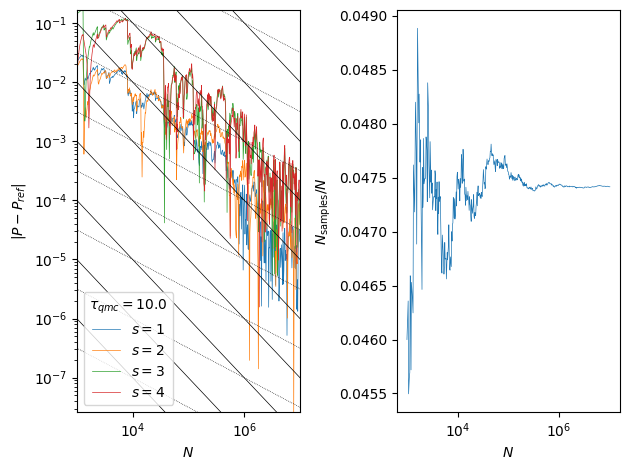

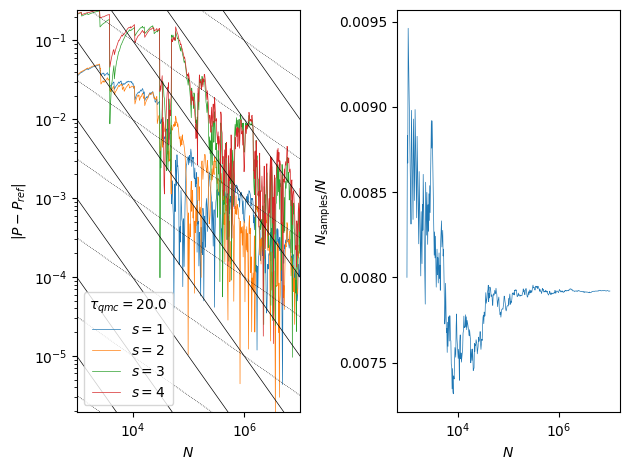

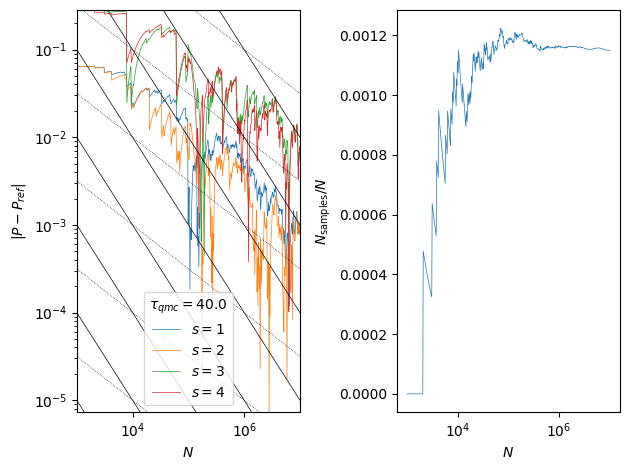

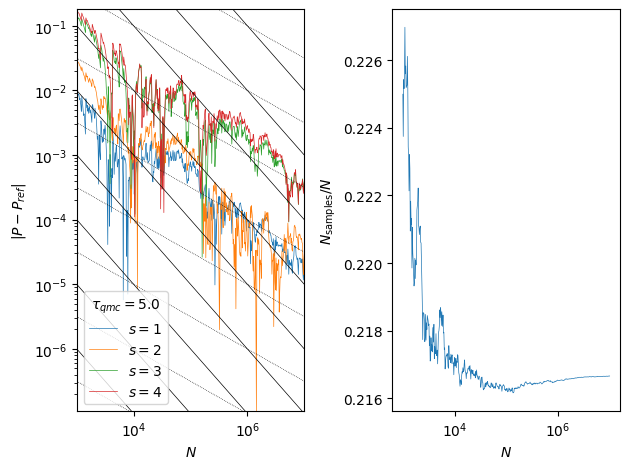

In [38]:
h5open("2nd_order_inchworm.h5", "r") do file
    for τ_qmc_group in file["scan_N_range"]
        τ_qmc = τ_qmc_group["tau_qmc"][]
        N_list = τ_qmc_group["N_list"][:]
        N_samples_list = τ_qmc_group["N_samples_list"][:]
        ref = τ_qmc_group["ref"][]
        div = τ_qmc_group["div"][:,:]
        plot_N_convergence("2nd_order_inchworm_N_scan_tau$τ_qmc.pdf", τ_qmc, N_list, N_samples_list, div)
    end
end

## Numerical experiments with the 2nd order diagram (`Sort` transformation)

In [46]:
# Scan a range of qRNG point numbers N using the `Sort` transformation and incremental evaluation of the integral
function scan_N_range_sort(N_list::Vector{Int}; verbose = false)
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    chunks = zeros(Complex{Float64}, 4, length(N_steps))
    
    seq = SobolSeq(3)
    N = 0
    for (i, N_step) in collect(Iterators.enumerate(N_steps))        
        chunk = do_2nd_order_inchworm_diagram_sort(seq, N_step)
        chunk *= N_step
        chunks[:, i] = [chunk[s][2][1] for s = 1:4]
        
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[:, i])")
            flush(stdout)
        end
        N += N_step
    end
    
    results = cumsum(chunks, dims=2)
    for i = 1:length(N_steps)
        results[:, i] /= N_list[i]
    end
    results
end

scan_N_range_sort (generic function with 1 method)

In [51]:
N_list = round.(Int, exp10.(range(2, 6, length=500)))

ref = delaunay_res[end, :]

@time results = scan_N_range_sort(N_list)
div = results - (ref .* ones(ComplexF64, length(N_list))')
    
h5_write_results("scan_N_range_sort", ref, N_list, results, div)

1310.423625 seconds (23.04 G allocations: 1.860 TiB, 15.91% gc time)


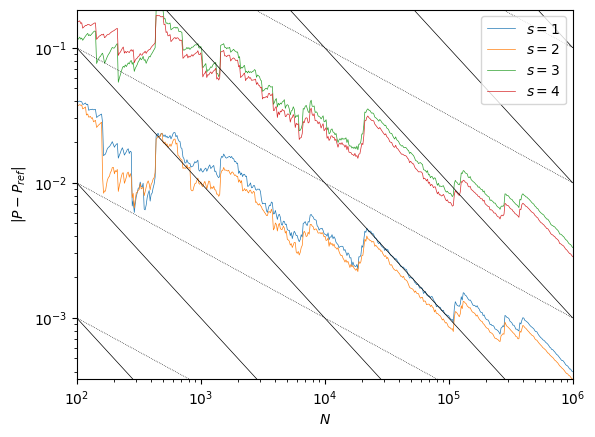

In [52]:
h5open("2nd_order_inchworm.h5", "r") do file
    gr = file["scan_N_range_sort"]
    N_list = gr["N_list"][:]
    ref = gr["ref"][]
    div = gr["div"][:,:]
    plot_N_convergence("2nd_order_inchworm_sort.pdf", N_list, div)
end